In [2]:
import numpy as np
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import re
import pandas as pd
from typing import Dict, List

In [5]:


# ================== 설정 ==================
PROFILE_TXT = Path("250829_104449_last 13 lines_and first 3 from prev 30 iter.txt")
BO_CSV      = Path("250914_cnt ink_27gage_avg-0_3std.csv")
AVG_COL     = "avg_val"          # 평균 컬럼
STD_COL     = "std_val"          # 표준편차 컬럼
OUT_TXT     = PROFILE_TXT.with_name("filtered_profiles_avg_std.txt")
OUT_REPORT  = PROFILE_TXT.with_name("filtered_profiles_avg_std_report.csv")

ATOL_AVG = 1e-2    # 평균 매칭 허용오차
ATOL_STD = 1e-2    # 표준편차 매칭 허용오차
USE_SAMPLE_STD = True  # 샘플 표준편차(ddof=1) 사용할지 여부
# ==========================================

def parse_numbers(line: str) -> np.ndarray:
    """텍스트 라인에서 숫자만 추출하여 float 배열 반환"""
    vals = []
    for token in line.split(","):
        t = token.strip()
        if t.startswith("+"):
            t = t[1:]
        try:
            vals.append(float(t))
        except:
            pass
    return np.asarray(vals, dtype=float)

def main():
    # 1) BO 데이터 로드
    bo_df = pd.read_csv(BO_CSV)
    if AVG_COL not in bo_df.columns or STD_COL not in bo_df.columns:
        raise ValueError(f"CSV에 '{AVG_COL}', '{STD_COL}' 컬럼이 모두 있어야 합니다. 현재 컬럼: {list(bo_df.columns)}")

    bo_avgs = bo_df[AVG_COL].astype(float).to_numpy()
    bo_stds = bo_df[STD_COL].astype(float).to_numpy()

    # 2) 프로파일 라인 읽기
    with open(PROFILE_TXT, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f if ln.strip()]

    kept_lines = []
    report_rows = []

    for idx, line in enumerate(lines):
        arr = parse_numbers(line)
        if arr.size == 0:
            continue

        ddof = 1 if USE_SAMPLE_STD and arr.size > 1 else 0
        avg = float(np.mean(arr))
        std = float(np.std(arr, ddof=ddof))

        # 3) CSV 값과 동시에 매칭 확인
        diffs_avg = np.abs(bo_avgs - avg)
        diffs_std = np.abs(bo_stds - std)

        # 평균, 표준편차 모두 허용오차 이내인 row 찾기
        matches = np.where((diffs_avg <= ATOL_AVG) & (diffs_std <= ATOL_STD))[0]
        matched = len(matches) > 0

        if matched:
            kept_lines.append(line)

        report_rows.append({
            "line_index": idx,
            "n_points": int(arr.size),
            "computed_avg": avg,
            "computed_std": std,
            "closest_bo_avg": float(bo_avgs[np.argmin(diffs_avg)]),
            "closest_bo_std": float(bo_stds[np.argmin(diffs_std)]),
            "min_diff_avg": float(np.min(diffs_avg)),
            "min_diff_std": float(np.min(diffs_std)),
            "matched_within_tol": matched,
            "matched_rows": matches.tolist()
        })

    # 4) 결과 저장
    with open(OUT_TXT, "w", encoding="utf-8") as f:
        for ln in kept_lines:
            f.write(ln + "\n")

    pd.DataFrame(report_rows).to_csv(OUT_REPORT, index=False)

    print(f"[완료] 매칭된 라인 수: {len(kept_lines)} / 총 라인 수: {len(lines)}")
    print(f" - 필터 결과: {OUT_TXT}")
    print(f" - 매칭 리포트: {OUT_REPORT}")
    if len(kept_lines) == 0:
        print("⚠️ 매칭된 라인이 없습니다. ATOL 값을 키워보세요.")


main()


[완료] 매칭된 라인 수: 16 / 총 라인 수: 468
 - 필터 결과: filtered_profiles_avg_std.txt
 - 매칭 리포트: filtered_profiles_avg_std_report.csv


In [4]:
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Optional

# ===================== 경로/파일 설정 =====================
TXT_PATH = Path("filtered_profiles_avg_std.txt")
CSV_PATH = Path("bo_log.csv")
IMG_DIR  = Path("images")   # 작업 폴더 기준; 필요 시 절대경로로 변경


# _0000000191_IMG_INTENSITY, _0000000191_INTENSITY, _0000000191_IMG_HEIGHT 모두 매칭
seq_pat = re.compile(r"_(\d{6,})_(?:IMG_)?(INTENSITY|HEIGHT)", re.IGNORECASE)

def build_iter2path(img_dir: Path, prefer: str = "INTENSITY") -> Dict[int, Path]:
    """
    - INTENSITY/HEIGHT 모두 인식
    - 동일 시퀀스 번호에 둘 다 있으면 prefer 쪽을 우선
    - 시퀀스 번호가 중간에 비어도, 정렬 후 'k번째 파일 -> iter k' 로 매핑
    """
    by_seq: Dict[int, Dict[str, Path]] = {}
    unmatched: List[str] = []
    exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
    for p in img_dir.rglob("*"):
        if p.is_file() and p.suffix.lower() in exts:
            m = seq_pat.search(p.name)
            if not m:
                unmatched.append(p.name)
                continue
            seq = int(m.group(1))
            kind = m.group(2).upper()  # "INTENSITY" or "HEIGHT"
            if seq not in by_seq:
                by_seq[seq] = {}
            # 같은 kind가 이미 있으면 그대로 두거나 교체—여기선 최초만 채택
            if kind not in by_seq[seq]:
                by_seq[seq][kind] = p

    if not by_seq:
        raise RuntimeError("이미지에서 시퀀스 번호를 찾지 못했습니다. (정규식/경로 확인)")

    seqs_sorted = sorted(by_seq.keys())

    # 각 시퀀스에서 prefer 우선, 없으면 다른 종류 사용
    ordered_paths: List[Path] = []
    for s in seqs_sorted:
        d = by_seq[s]
        if prefer in d:
            ordered_paths.append(d[prefer])
        elif "INTENSITY" in d:
            ordered_paths.append(d["INTENSITY"])
        elif "HEIGHT" in d:
            ordered_paths.append(d["HEIGHT"])

    # ‘k번째 파일 -> iter k’ 매핑
    iter2path: Dict[int, Path] = {i + 1: p for i, p in enumerate(ordered_paths)}
    return iter2path



# ===================== 파싱/보조 함수 =====================
def parse_numbers(line: str) -> np.ndarray:
    vals = []
    for tok in line.split(","):
        t = tok.strip()
        if t.startswith("+"):
            t = t[1:]
        try:
            vals.append(float(t))
        except:
            pass
    return np.asarray(vals, dtype=float)

def gaussian_kde(x: np.ndarray, grid: np.ndarray) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    if x.size < 2:
        return np.zeros_like(grid)
    s = float(np.std(x, ddof=1))
    if s == 0.0:
        mu = float(np.mean(x))
        eps = 1e-6
        return np.exp(-0.5*((grid-mu)/eps)**2)/(np.sqrt(2*np.pi)*eps)
    # Silverman’s rule
    h = max(1.06 * s * (x.size ** (-1/5)), 1e-6)
    u = (grid[:, None] - x[None, :]) / h
    kern = np.exp(-0.5*u**2) / (np.sqrt(2*np.pi)*h)
    return np.mean(kern, axis=1)

def make_common_grid(arrays: List[np.ndarray], pad_ratio: float = 0.1, n: int = 600) -> np.ndarray:
    xmin = min(float(a.min()) for a in arrays if a.size > 0)
    xmax = max(float(a.max()) for a in arrays if a.size > 0)
    pad  = pad_ratio * (xmax - xmin + 1e-12)
    return np.linspace(xmin - pad, xmax + pad, n)

# ===================== 핵심 함수 =====================
def show_iteration(
    iteration: int,
    img_dir: Path = IMG_DIR,
    txt_path: Path = TXT_PATH,
    csv_path: Path = CSV_PATH,
    bins: int = 50,
    save_path: Optional[Path] = None,
):
    # --- 데이터 로드 ---
    with open(txt_path, "r", encoding="utf-8") as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    df = pd.read_csv(csv_path)

    N = min(len(lines), len(df))
    if iteration < 1 or iteration > N:
        raise ValueError(f"iteration은 1~{N} 범위여야 합니다.")

    idx = iteration - 1
    arr_target = parse_numbers(lines[idx])
    if arr_target.size == 0:
        raise ValueError(f"{idx}번째 줄에서 숫자를 찾지 못했습니다.")

    # --- 이미지 경로 매핑 ---
    iter2path = build_iter2path(img_dir)
    img_path = iter2path.get(iteration, None)

    # --- 1) CSV: timestamp 제외 전부 프린트 (소수점 3자리로) ---
        # --- 1) CSV 값 출력 (소수점 3자리, 보기 좋은 포맷) ---
    row = df.iloc[idx].to_dict()

    score = round(float(row.get("objective_for_BO", np.nan)), 3)

    print(f"iter = {iteration}")

    print() 
    print(f"score = {score}")
    print() 
    print("profile analysis")
    for k in ["norm_avg", "norm_std", "avg_val", "std_val"]:
        if k in row:
            try:
                print(f"  - {k}: {round(float(row[k]), 3)}")
            except:
                print(f"  - {k}: {row[k]}")

    print() 
    print("parameters")
    if "acquisition" in row:
        print(f"  - acquisition: {row['acquisition']}")
    for k in ["pressure", "velocity", "wall_spacing", "number_of_layers"]:
        if k in row:
            try:
                print(f"  - {k}: {round(float(row[k]), 3)}")
            except:
                print(f"  - {k}: {row[k]}")


    # --- 모든 iteration 분포 준비(오버레이용) ---
    all_arrays = [parse_numbers(ln) for ln in lines]
    all_arrays = [a for a in all_arrays if a.size > 0]
    grid = make_common_grid(all_arrays)

    # --- 그림: [이미지 | 단일 density | 전체 오버레이 + 타깃] ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={"width_ratios": [1.1, 1, 1]})

    # (왼쪽) 이미지
    ax0 = axes[0]
    if img_path is not None and img_path.exists():
        from PIL import Image
        im = Image.open(img_path)
        if im.mode not in ("L", "I;16"):
            im = im.convert("L")
        arr = np.array(im)
        if arr.dtype == np.uint8:
            vmin, vmax = 0, 255
        elif arr.dtype == np.uint16:
            vmin, vmax = 0, 65535
        else:
            lo, hi = np.percentile(arr, [0.5, 99.5])
            vmin, vmax = float(lo), float(hi)
        ax0.imshow(arr, cmap="gray", vmin=vmin, vmax=vmax)
        ax0.set_title(f"Iteration {iteration}\n{img_path.name}", fontsize=10)
        ax0.axis("off")
    else:
        ax0.axis("off")
        ax0.set_title(f"Iteration {iteration}\n(no image)", fontsize=10)

    # (가운데) 해당 iter의 value-density (히스토그램 + KDE)
    ax1 = axes[1]
    ax1.hist(arr_target, bins=bins, density=True, alpha=0.6, edgecolor="black")
    dens_t = gaussian_kde(arr_target, grid)
    ax1.plot(grid, dens_t, linewidth=2)
    ax1.set_title("value-density (this iter)")
    ax1.set_xlabel("Value")
    ax1.set_ylabel("Density")

    # 🔑 x축 범위 자동 조정 (1~99 퍼센타일)
    lo, hi = np.percentile(arr_target, [1, 99])
    pad = 0.05 * (hi - lo)
    ax1.set_xlim(lo - pad, hi + pad)

    # (오른쪽) 전체 오버레이
    ax2 = axes[2]
    for j, arr in enumerate(all_arrays, start=1):
        y = gaussian_kde(arr, grid)
        if j == iteration:
            ax2.plot(grid, y, color="red", linewidth=2.5, label=f"iter {iteration}")
        else:
            ax2.plot(grid, y, color="#F5C04A", alpha=0.6, linewidth=1.5)
    ax2.set_title("value-density overlay (all)")
    ax2.set_xlabel("Value")
    ax2.set_ylabel("Density")
    ax2.legend(loc="best")

    plt.tight_layout()

    if save_path is not None:
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"[saved] {save_path}")
        plt.close(fig)
    else:
        plt.show()




iter = 1

score = 0.403

profile analysis
  - norm_avg: 0.452
  - norm_std: 0.05
  - avg_val: 40.431
  - std_val: 0.497

parameters
  - acquisition: RANDOM
  - pressure: 468.445
  - velocity: 20.267
  - wall_spacing: 0.673
  - number_of_layers: 3.963


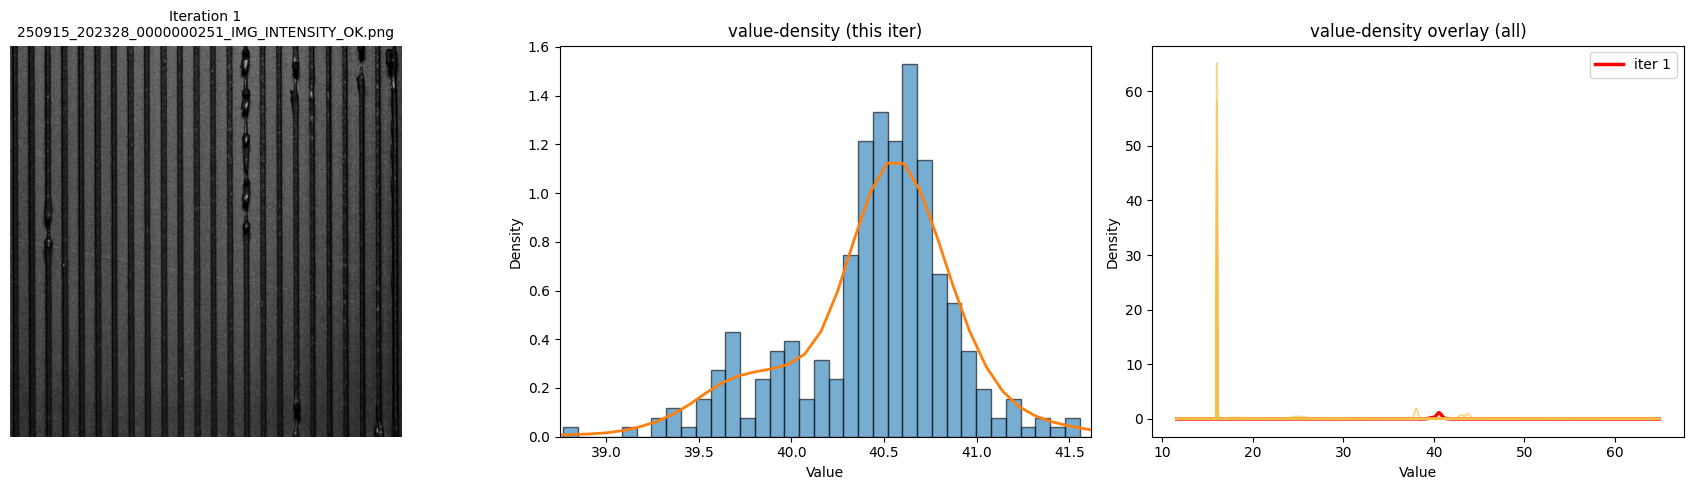

iter = 2

score = 0.466

profile analysis
  - norm_avg: 0.508
  - norm_std: 0.043
  - avg_val: 43.455
  - std_val: 0.426

parameters
  - acquisition: RANDOM
  - pressure: 473.623
  - velocity: 30.441
  - wall_spacing: 0.684
  - number_of_layers: 6.156


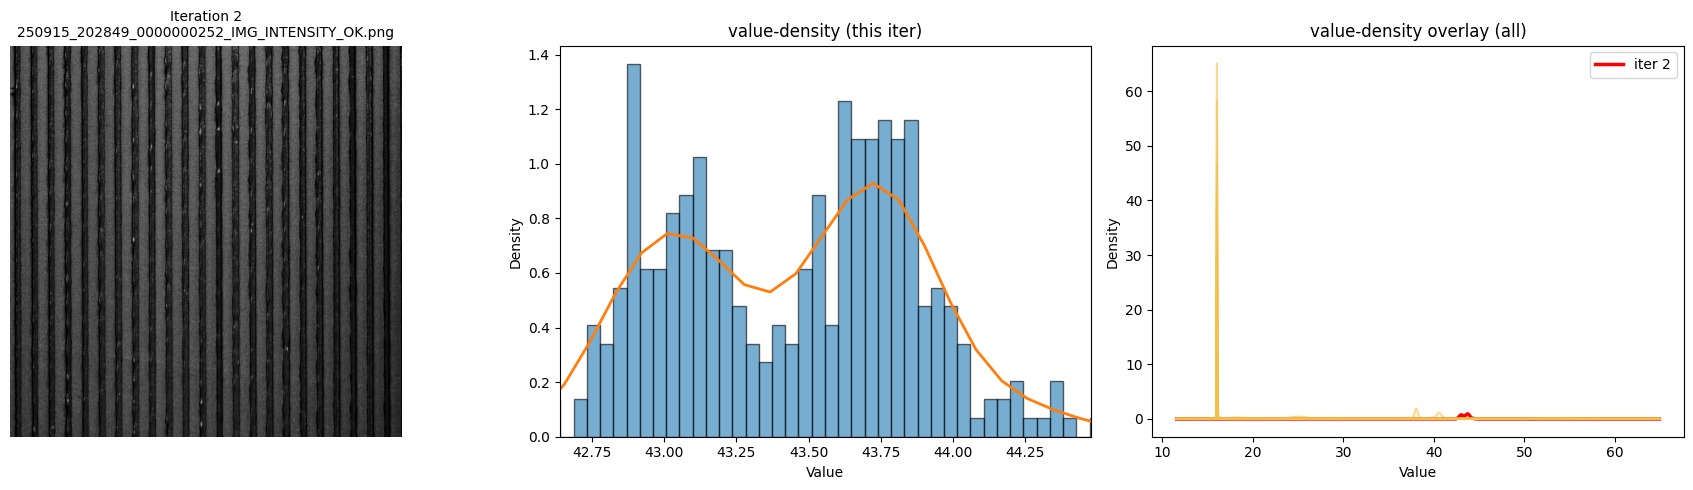

iter = 3

score = 0.376

profile analysis
  - norm_avg: 0.407
  - norm_std: 0.031
  - avg_val: 37.975
  - std_val: 0.307

parameters
  - acquisition: RANDOM
  - pressure: 497.427
  - velocity: 21.134
  - wall_spacing: 0.863
  - number_of_layers: 3.969


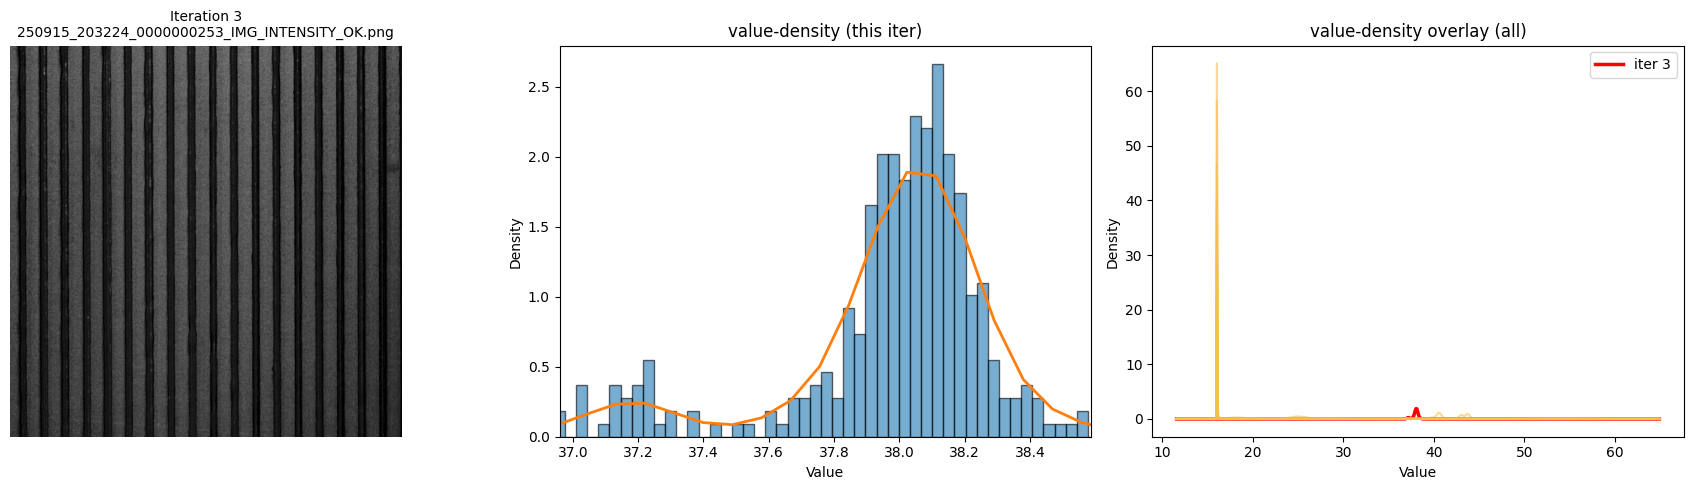

iter = 4

score = 0.481

profile analysis
  - norm_avg: 0.704
  - norm_std: 0.222
  - avg_val: 53.991
  - std_val: 2.225

parameters
  - acquisition: RANDOM
  - pressure: 459.798
  - velocity: 24.407
  - wall_spacing: 0.356
  - number_of_layers: 5.573


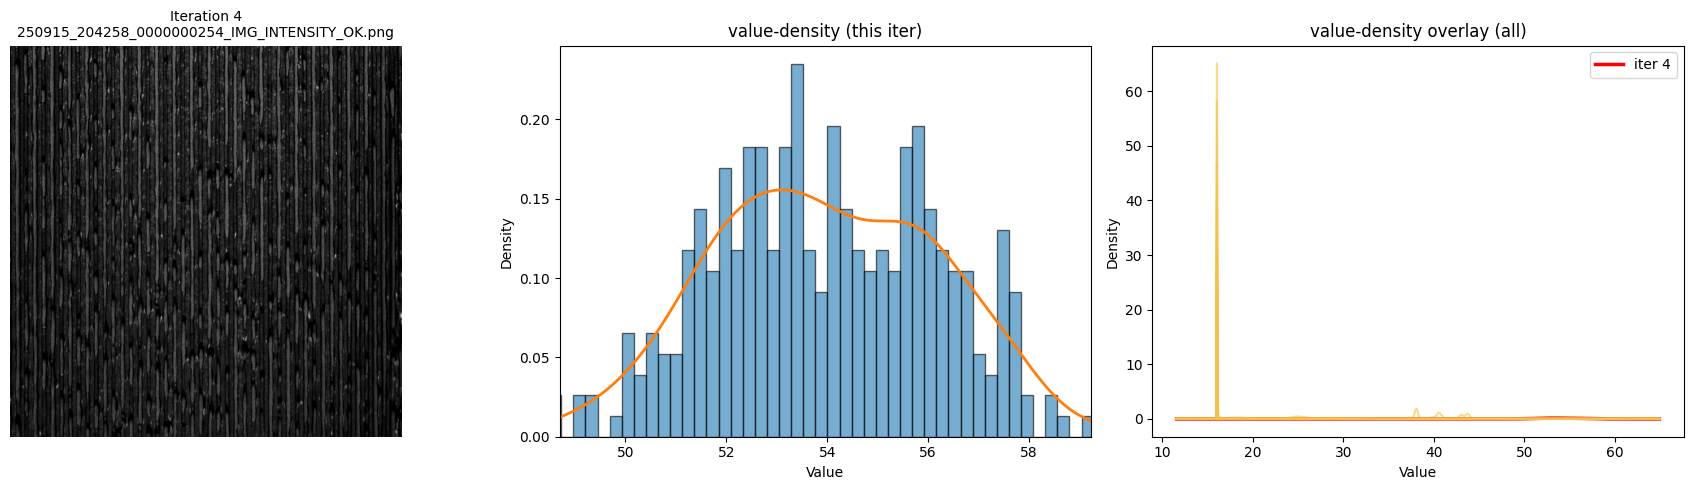

iter = 5

score = 0.084

profile analysis
  - norm_avg: 0.167
  - norm_std: 0.082
  - avg_val: 24.993
  - std_val: 0.823

parameters
  - acquisition: RANDOM
  - pressure: 487.153
  - velocity: 26.504
  - wall_spacing: 0.694
  - number_of_layers: 4.415


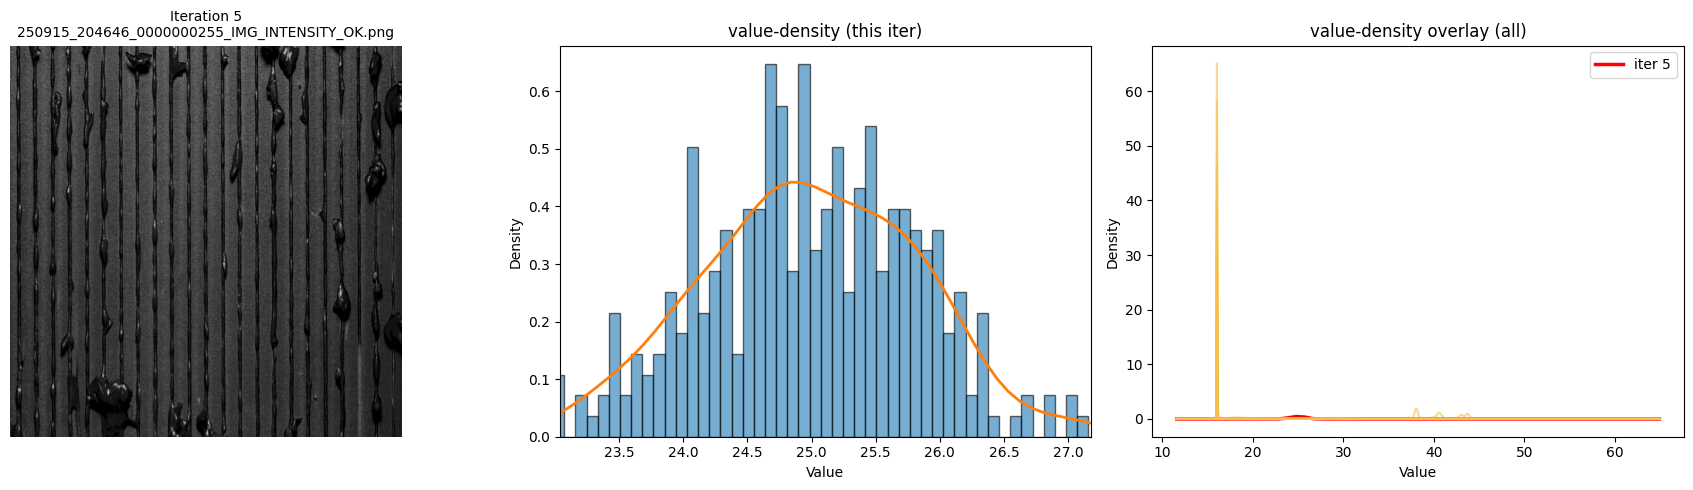

iter = 6

score = -0.196

profile analysis
  - norm_avg: 0.073
  - norm_std: 0.269
  - avg_val: 19.947
  - std_val: 2.691

parameters
  - acquisition: RANDOM
  - pressure: 462.659
  - velocity: 32.726
  - wall_spacing: 0.748
  - number_of_layers: 5.381


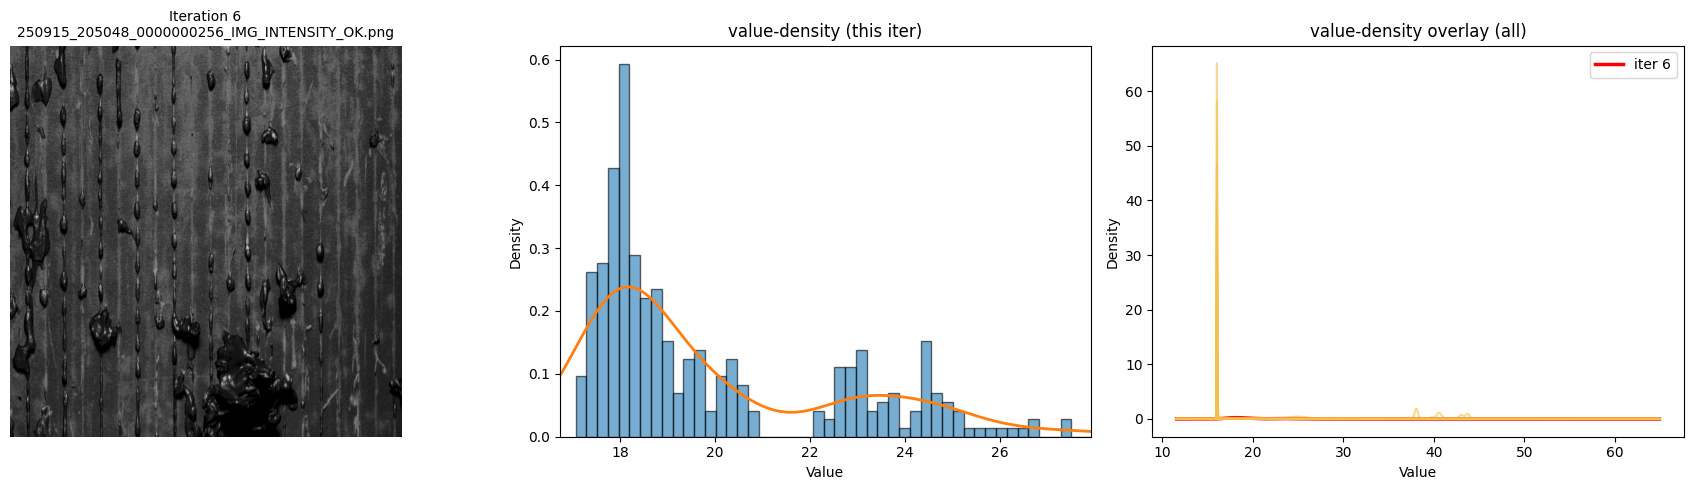

iter = 7

score = -0.02

profile analysis
  - norm_avg: 0.245
  - norm_std: 0.265
  - avg_val: 29.215
  - std_val: 2.648

parameters
  - acquisition: qUCB(beta=0.25)
  - pressure: 464.152
  - velocity: 25.305
  - wall_spacing: 0.413
  - number_of_layers: 5.805


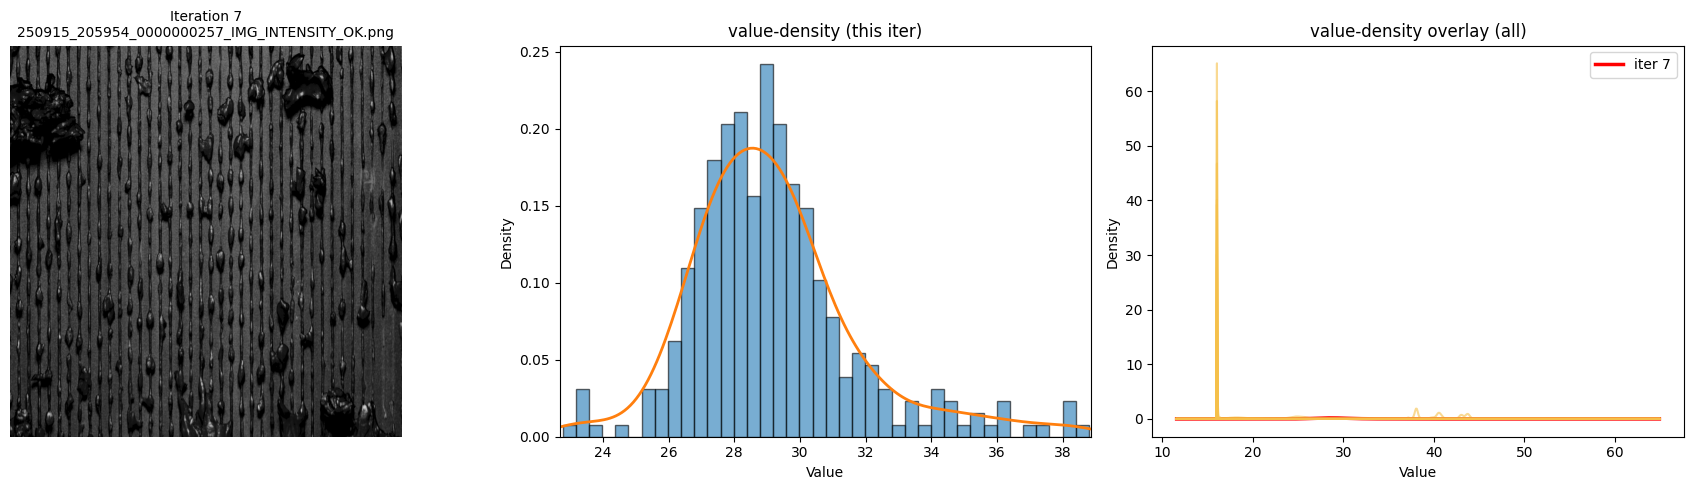

iter = 8

score = -0.193

profile analysis
  - norm_avg: 0.067
  - norm_std: 0.259
  - avg_val: 19.597
  - std_val: 2.593

parameters
  - acquisition: qUCB(beta=0.25)
  - pressure: 458.182
  - velocity: 23.162
  - wall_spacing: 0.293
  - number_of_layers: 5.529


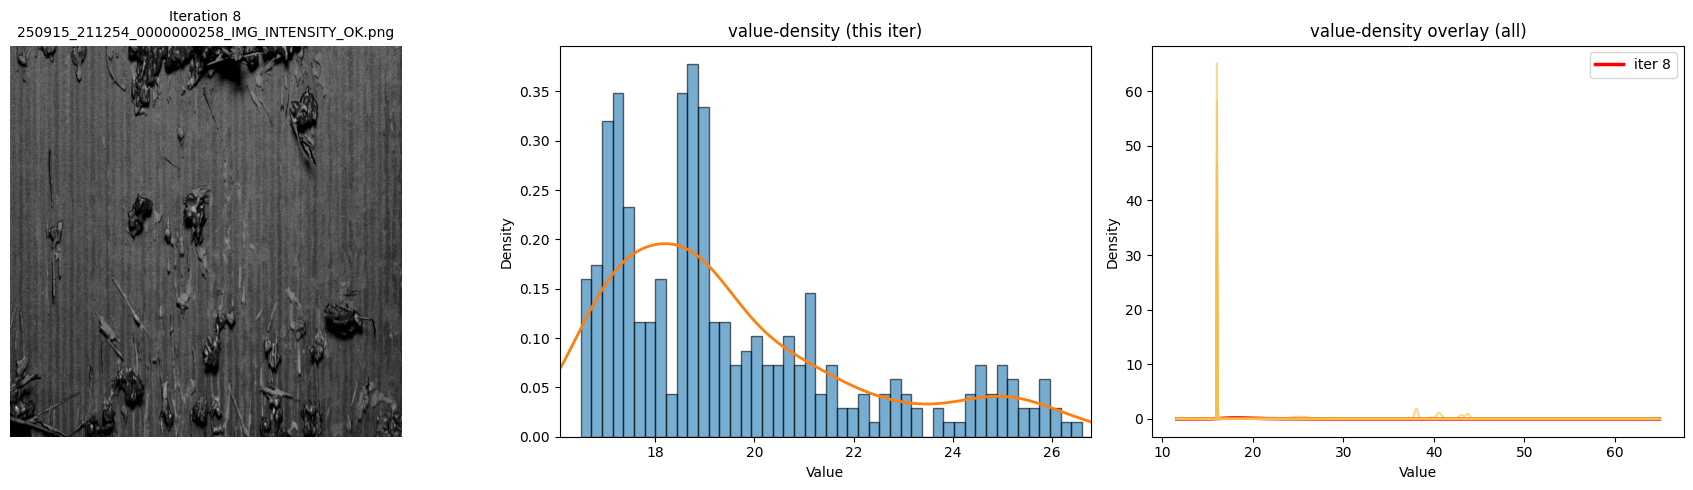

iter = 9

score = -0.002

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.004
  - avg_val: 16.068
  - std_val: 0.036

parameters
  - acquisition: qUCB(beta=0.25)
  - pressure: 454.892
  - velocity: 24.358
  - wall_spacing: 0.335
  - number_of_layers: 5.266


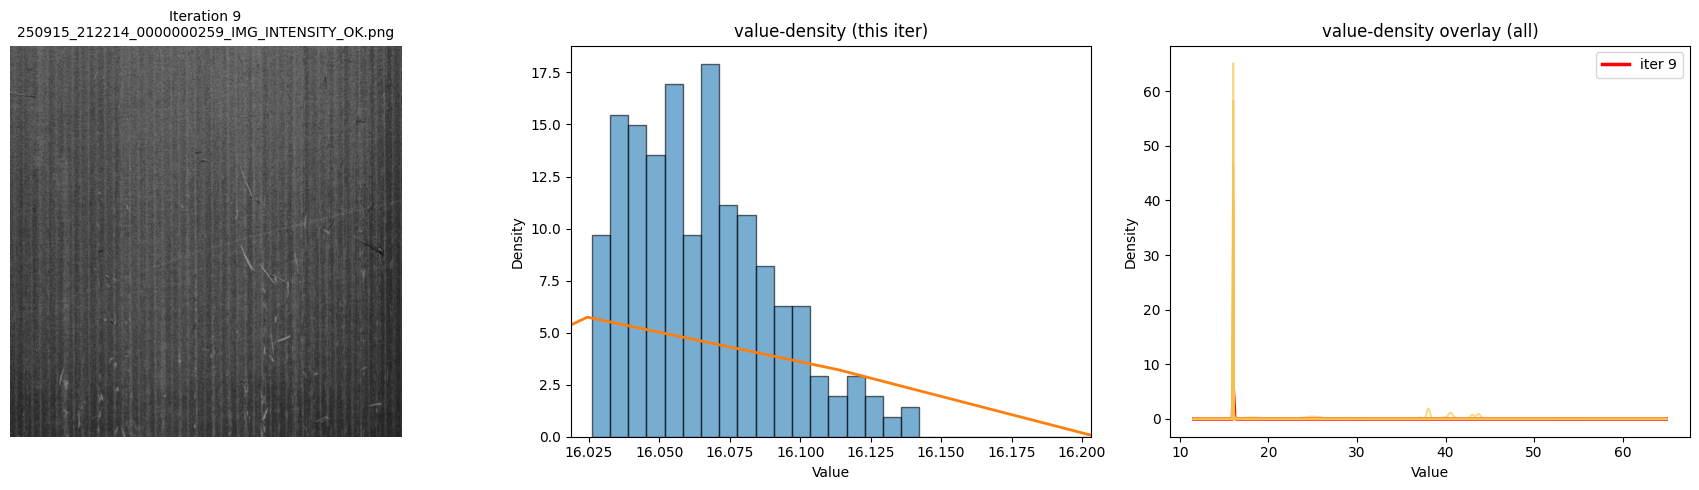

iter = 10

score = -0.003

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.004
  - avg_val: 16.056
  - std_val: 0.036

parameters
  - acquisition: qUCB(beta=0.25)
  - pressure: 467.569
  - velocity: 24.533
  - wall_spacing: 0.379
  - number_of_layers: 5.576


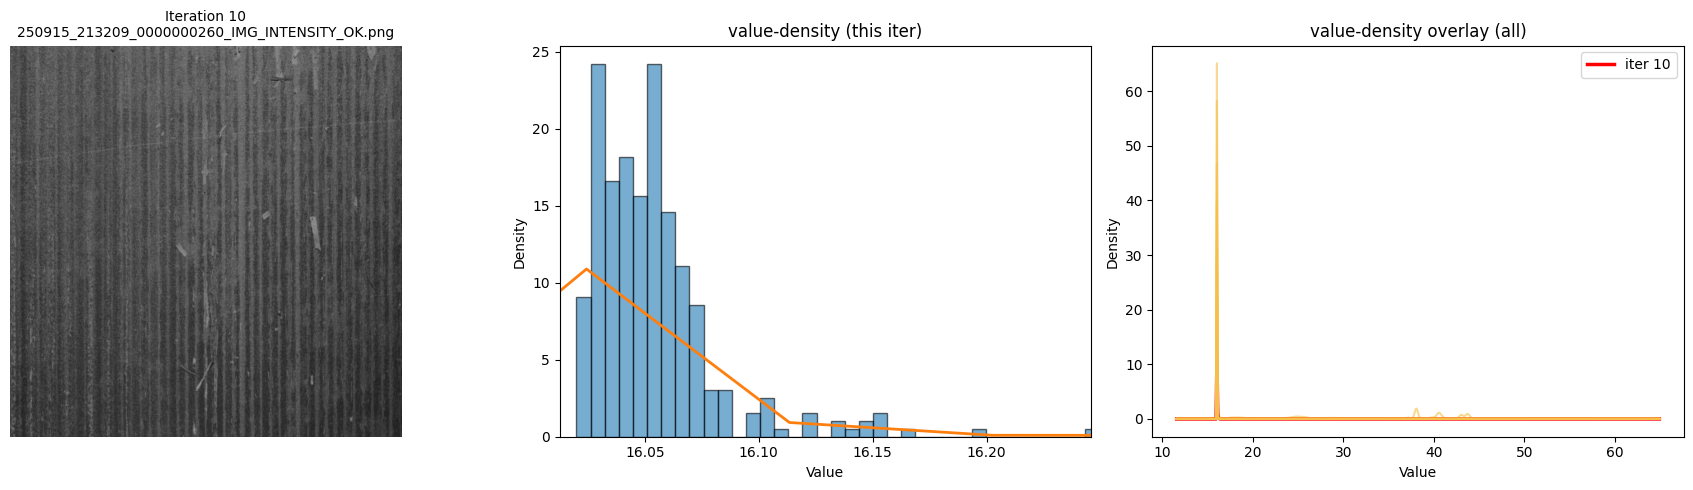

iter = 11

score = -0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.057
  - std_val: 0.013

parameters
  - acquisition: qUCB(beta=0.25)
  - pressure: 459.947
  - velocity: 24.591
  - wall_spacing: 0.37
  - number_of_layers: 5.765


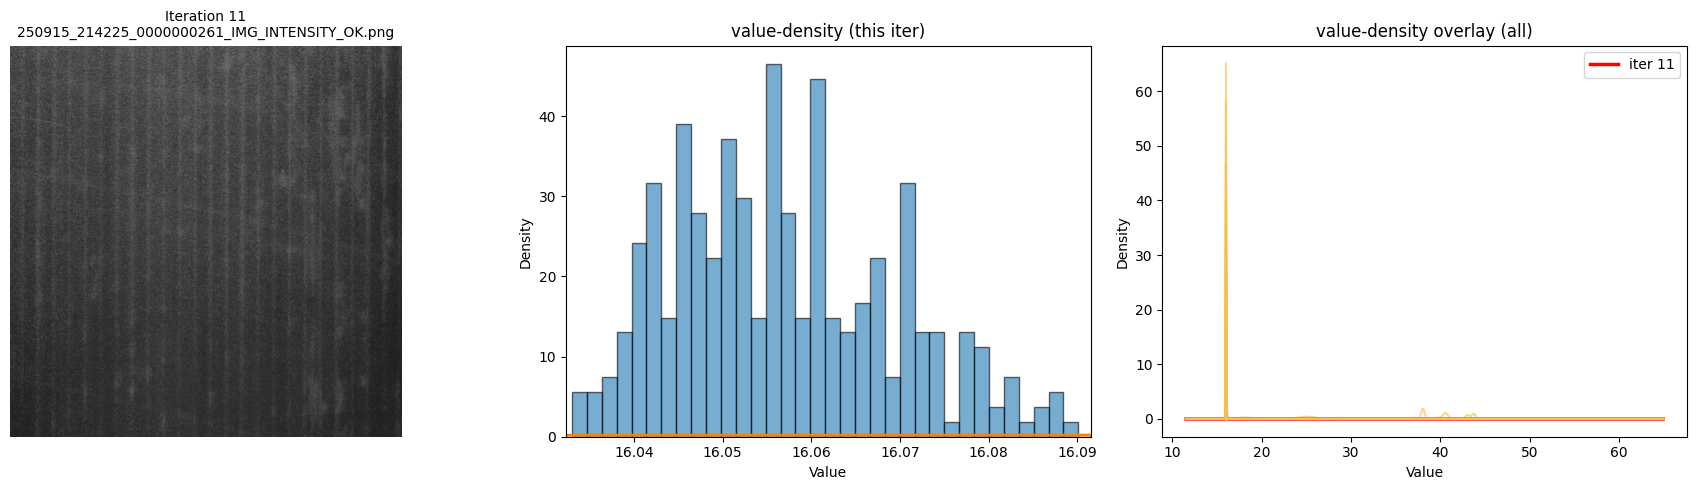

iter = 12

score = 0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.058
  - std_val: 0.01

parameters
  - acquisition: qUCB(beta=0.25)
  - pressure: 472.483
  - velocity: 30.539
  - wall_spacing: 0.652
  - number_of_layers: 6.163


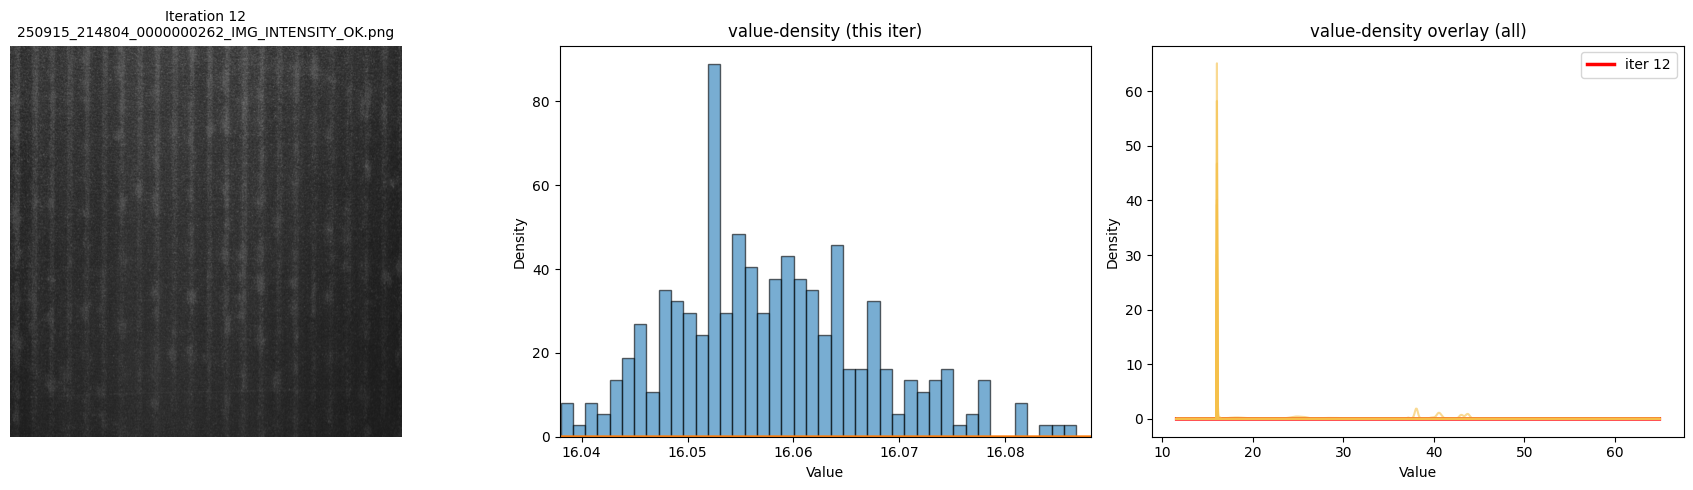

iter = 13

score = -0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.059
  - std_val: 0.015

parameters
  - acquisition: qUCB(beta=0.25)
  - pressure: 477.837
  - velocity: 20.0
  - wall_spacing: 0.796
  - number_of_layers: 3.617


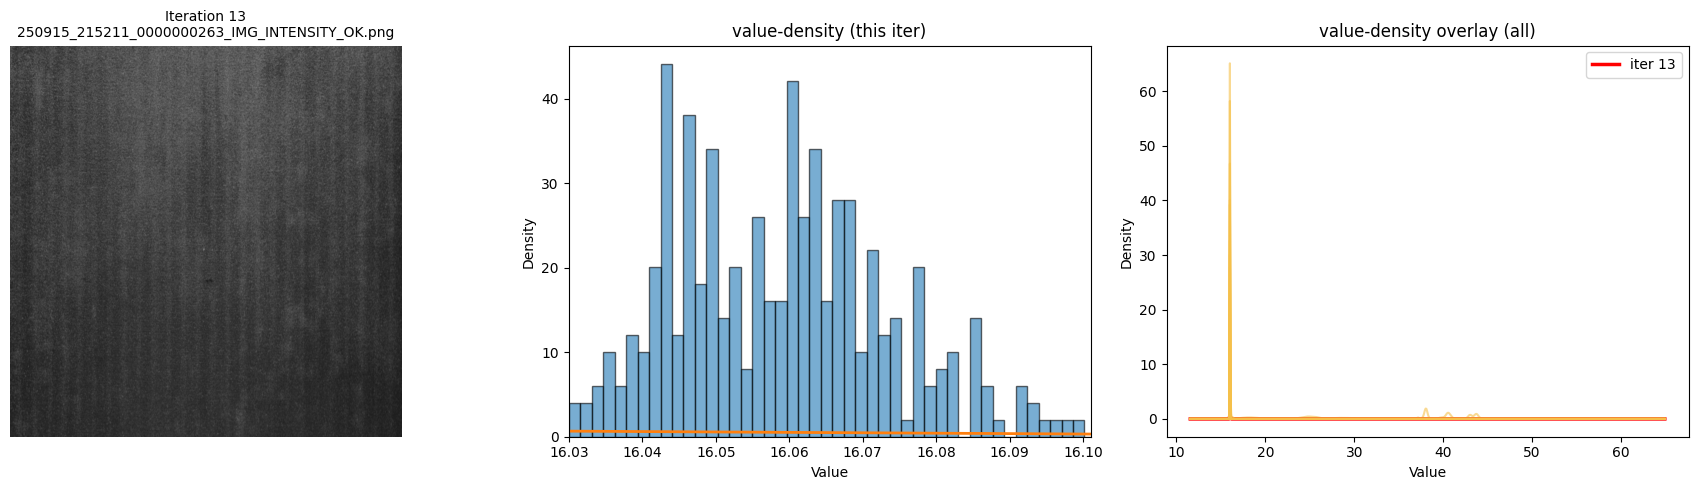

iter = 14

score = -0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.053
  - std_val: 0.013

parameters
  - acquisition: qUCB(beta=0.25)
  - pressure: 459.658
  - velocity: 24.19
  - wall_spacing: 0.351
  - number_of_layers: 5.573


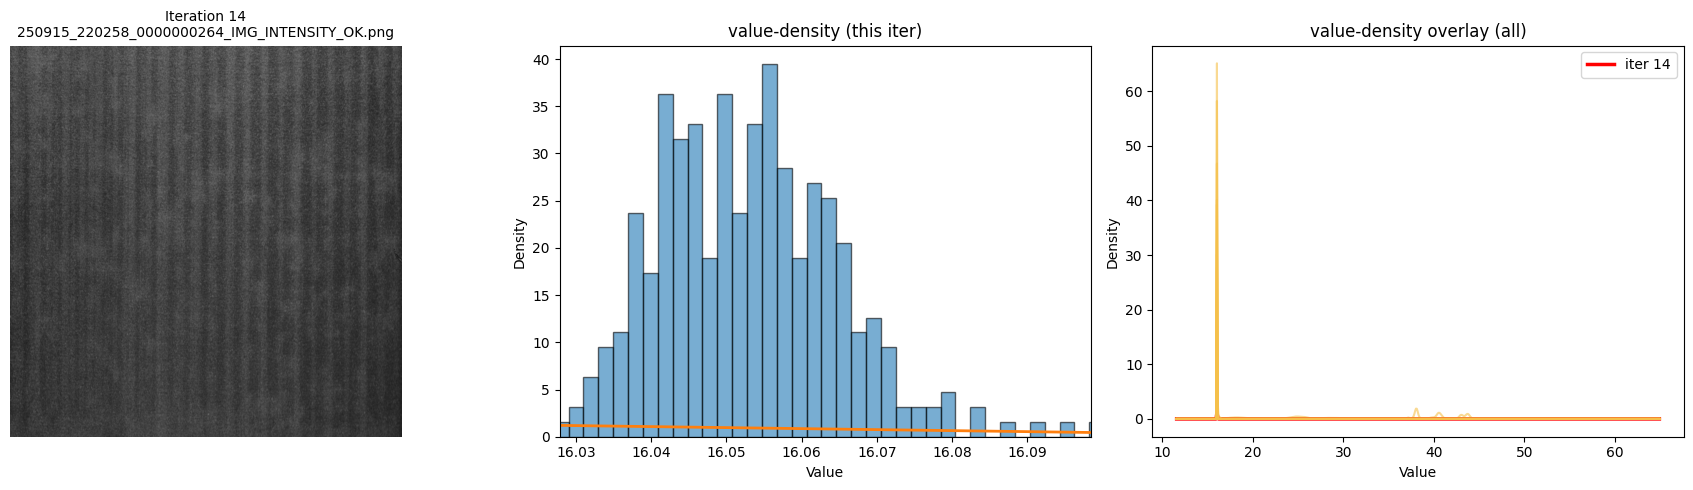

iter = 15

score = -0.001

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.002
  - avg_val: 16.055
  - std_val: 0.02

parameters
  - acquisition: qUCB(beta=0.25)
  - pressure: 472.93
  - velocity: 30.465
  - wall_spacing: 0.686
  - number_of_layers: 6.181


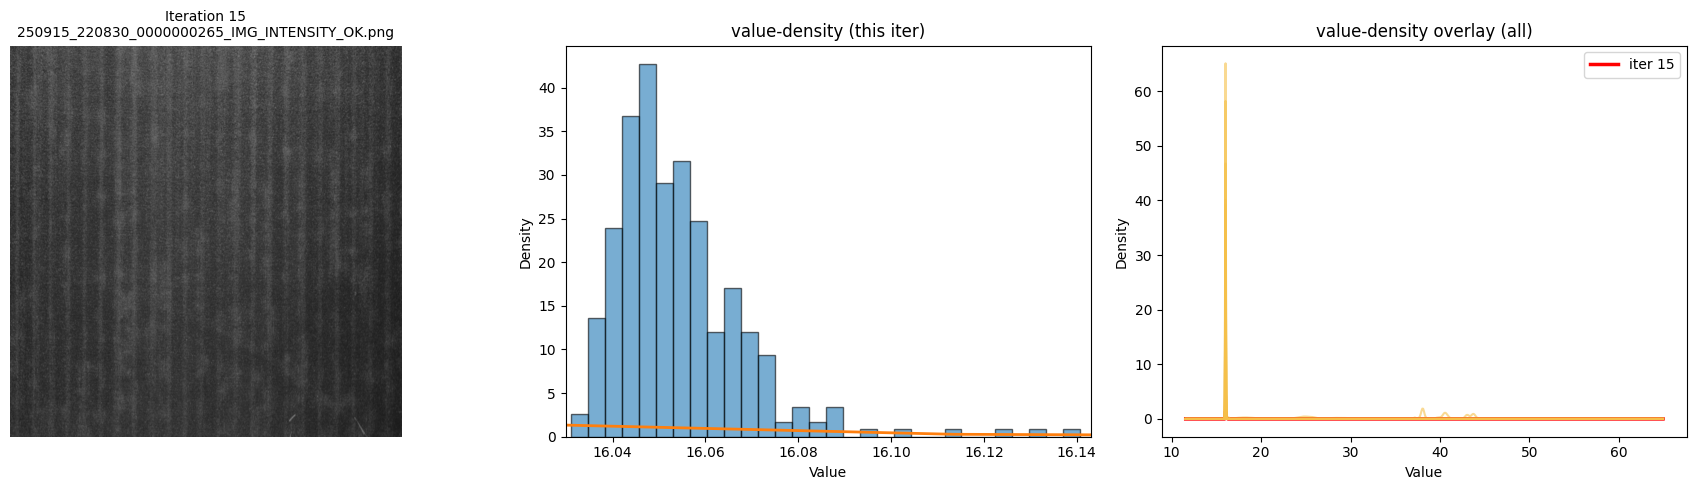

iter = 16

score = -0.005

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.006
  - avg_val: 16.068
  - std_val: 0.065

parameters
  - acquisition: qUCB(beta=0.25)
  - pressure: 498.829
  - velocity: 21.215
  - wall_spacing: 0.867
  - number_of_layers: 3.987


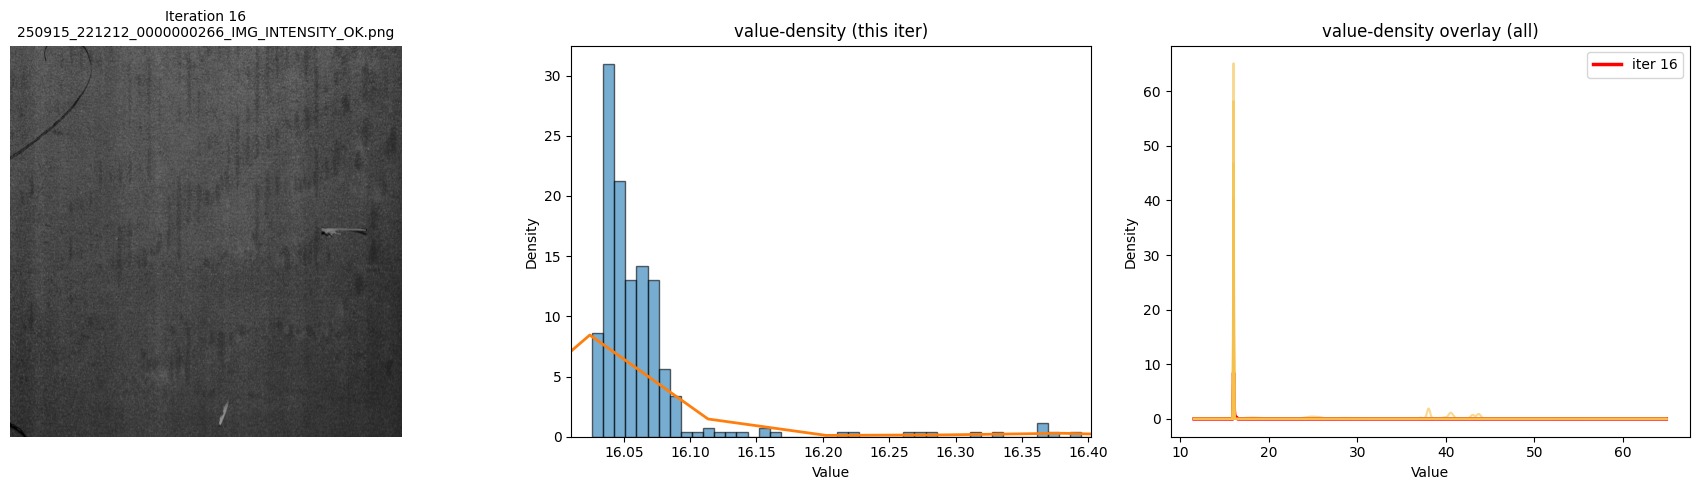

iter = 17

score = -0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.039
  - std_val: 0.008

parameters
  - acquisition: qUCB(beta=0.25)
  - pressure: 462.768
  - velocity: 20.0
  - wall_spacing: 0.615
  - number_of_layers: 4.251


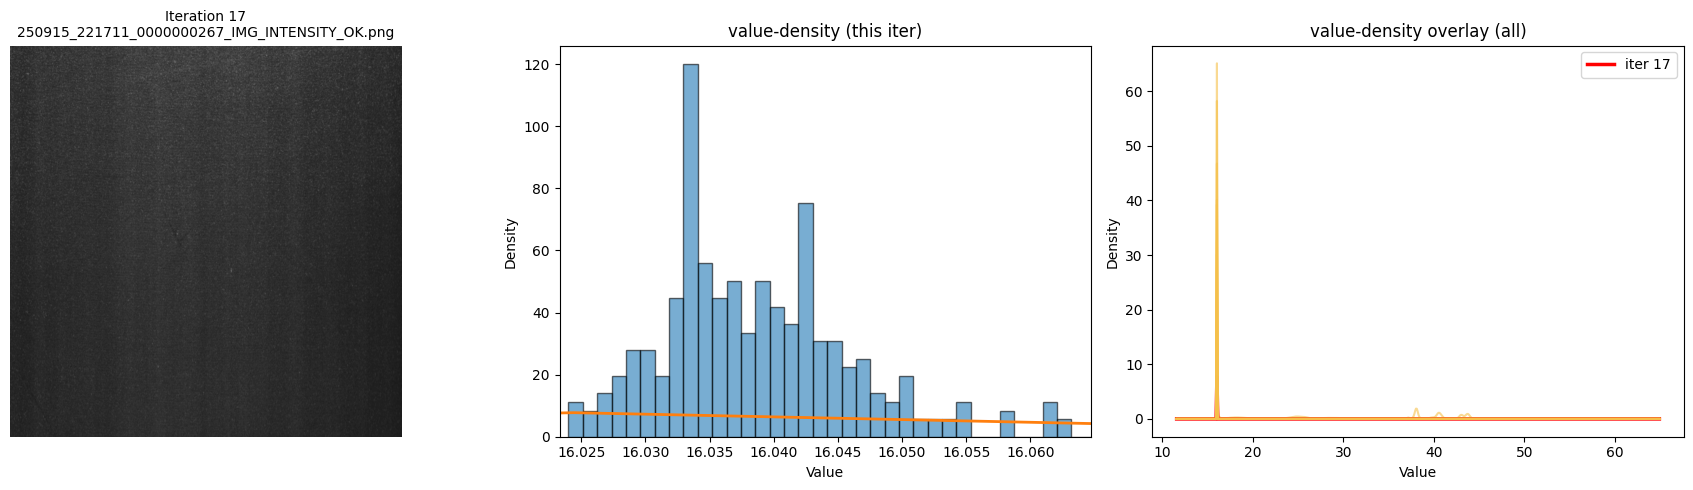

iter = 18

score = -0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.038
  - std_val: 0.008

parameters
  - acquisition: qUCB(beta=0.25)
  - pressure: 500.0
  - velocity: 22.366
  - wall_spacing: 0.912
  - number_of_layers: 6.636


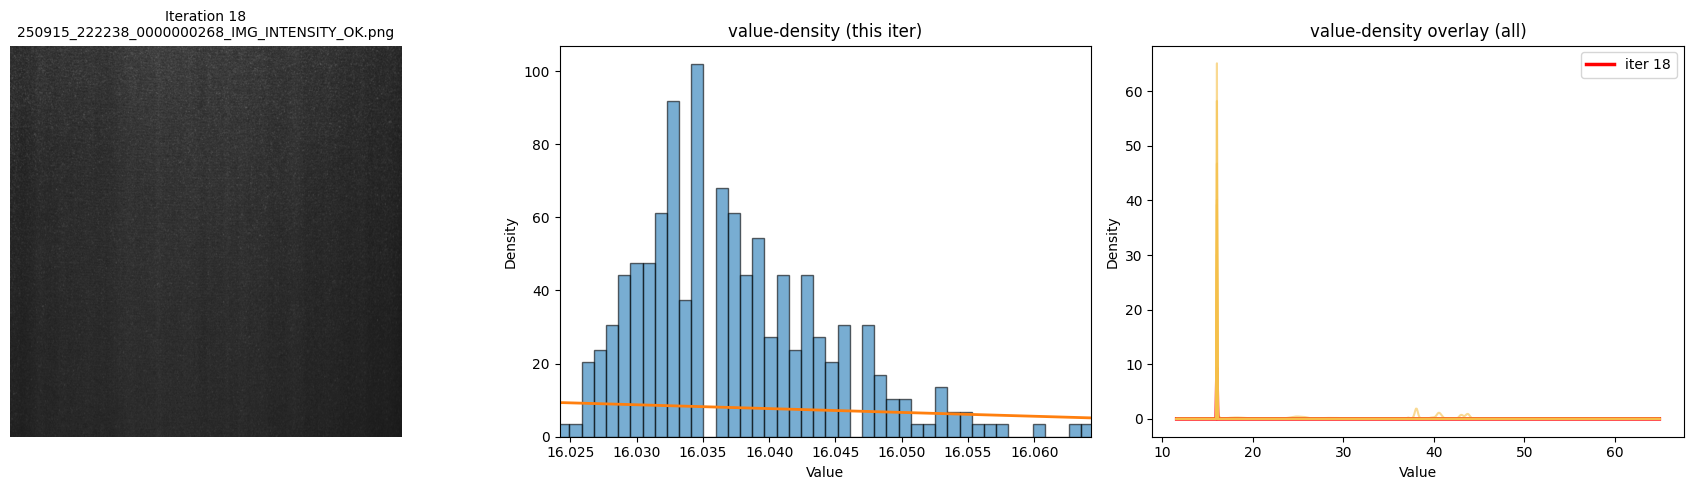

iter = 19

score = 0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.039
  - std_val: 0.007

parameters
  - acquisition: qLogNEI
  - pressure: 500.0
  - velocity: 40.0
  - wall_spacing: 0.2
  - number_of_layers: 8.5


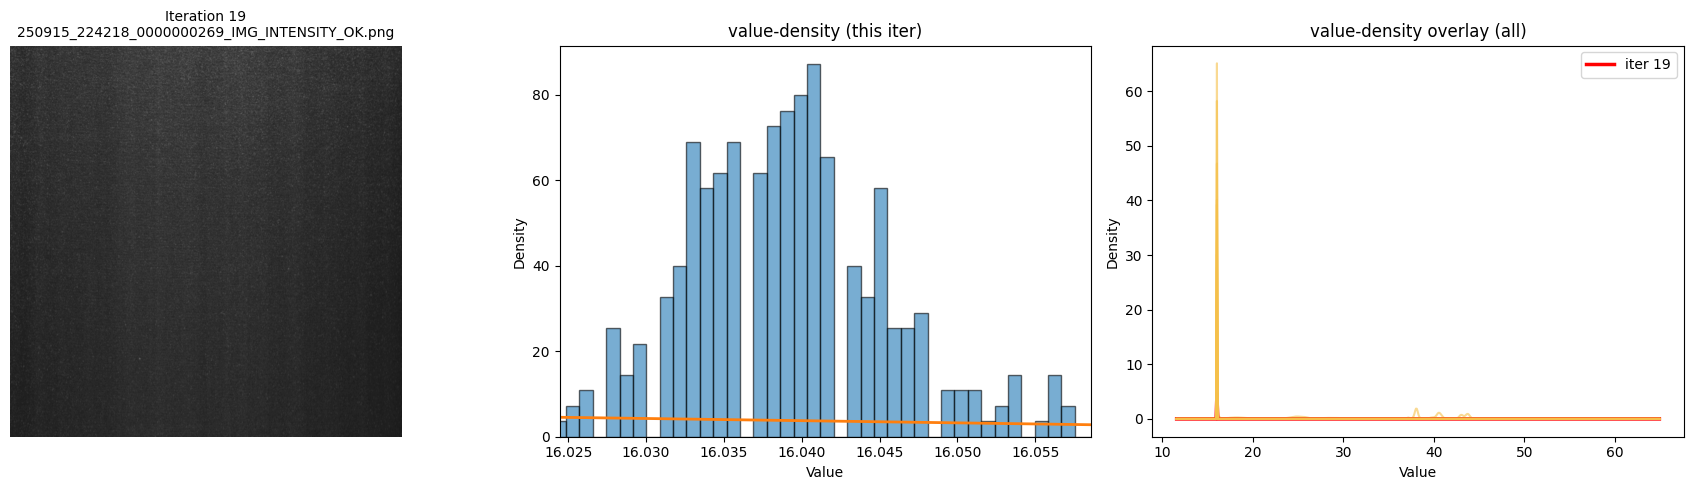

iter = 20

score = -0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.033
  - std_val: 0.007

parameters
  - acquisition: qLogNEI
  - pressure: 500.0
  - velocity: 20.0
  - wall_spacing: 0.2
  - number_of_layers: 3.5


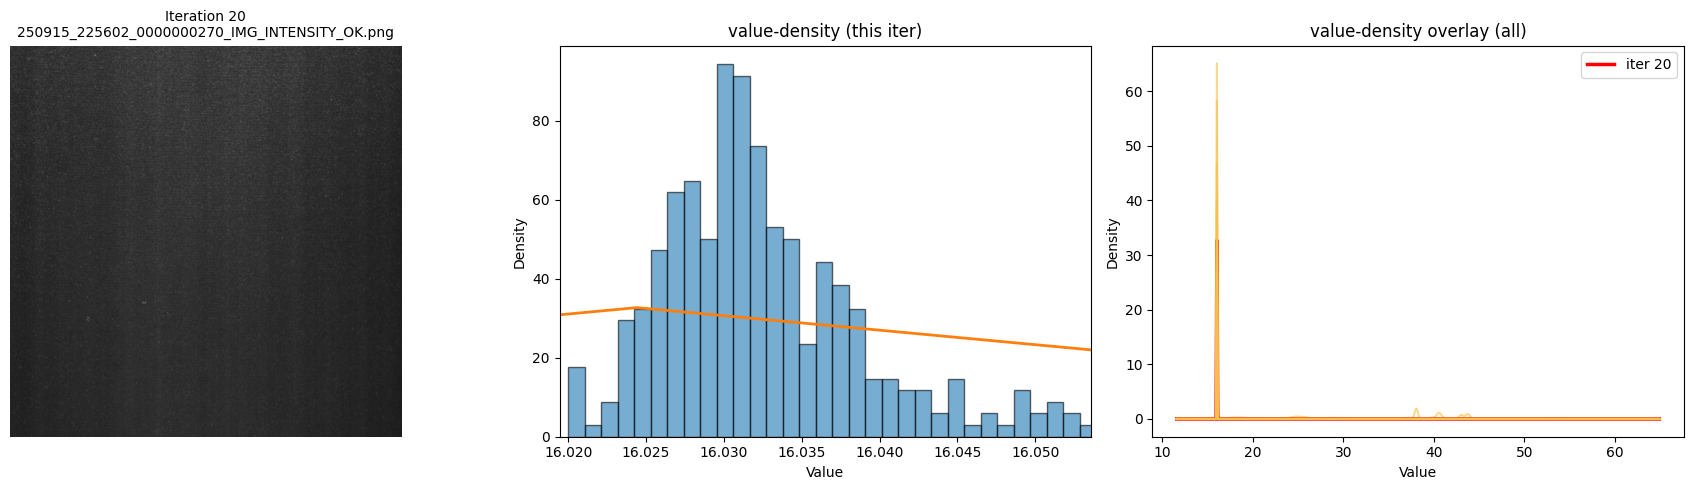

iter = 21

score = -0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.032
  - std_val: 0.007

parameters
  - acquisition: qLogNEI
  - pressure: 450.0
  - velocity: 20.0
  - wall_spacing: 1.0
  - number_of_layers: 8.5


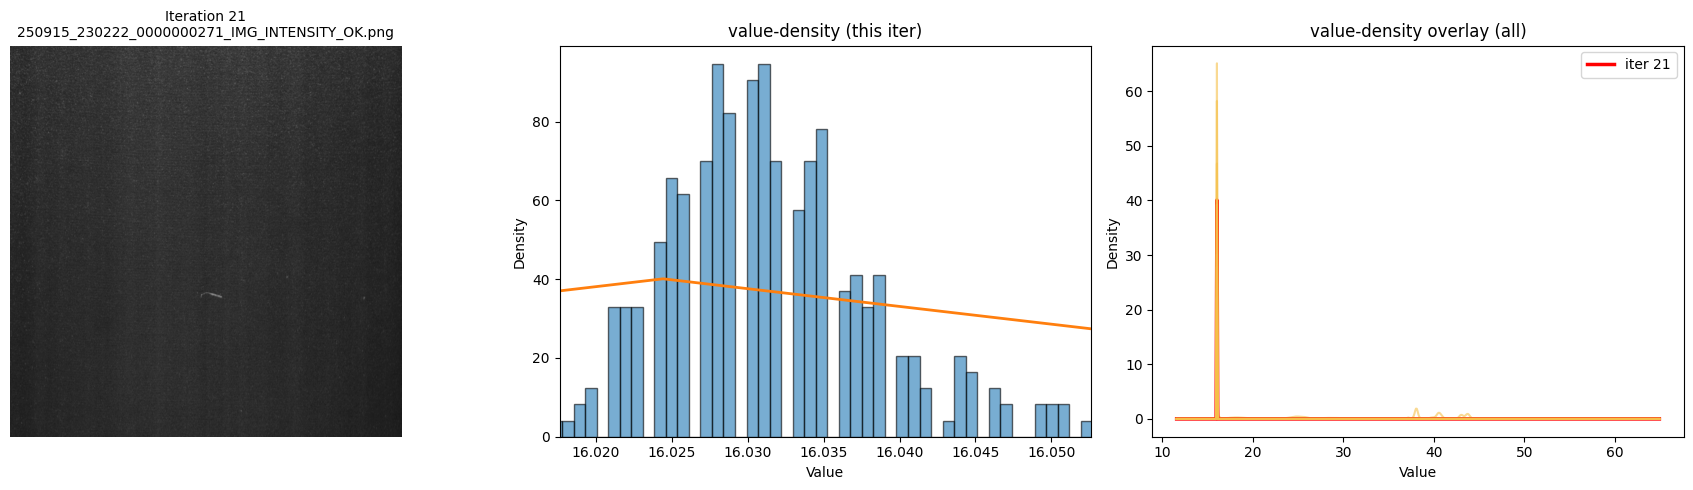

iter = 22

score = -0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.029
  - std_val: 0.006

parameters
  - acquisition: qLogNEI
  - pressure: 500.0
  - velocity: 40.0
  - wall_spacing: 1.0
  - number_of_layers: 3.5


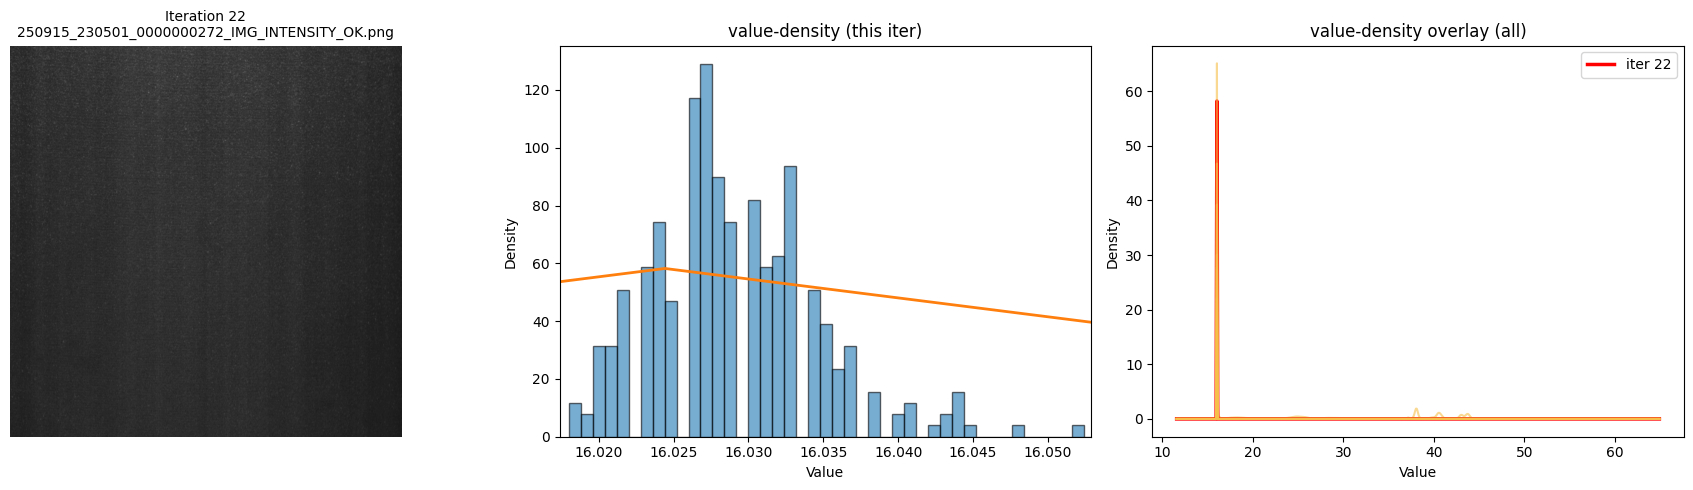

iter = 23

score = -0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.033
  - std_val: 0.008

parameters
  - acquisition: qLogNEI
  - pressure: 450.0
  - velocity: 20.0
  - wall_spacing: 1.0
  - number_of_layers: 3.5


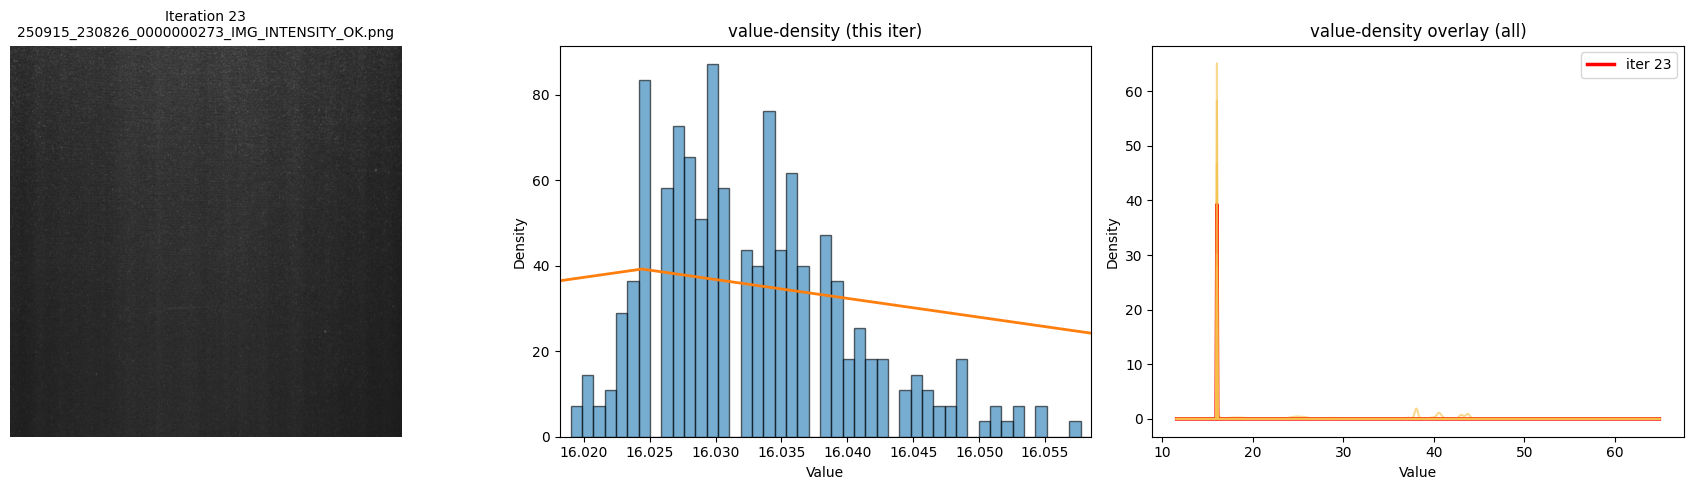

iter = 24

score = -0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.028
  - std_val: 0.006

parameters
  - acquisition: qLogNEI
  - pressure: 500.0
  - velocity: 20.0
  - wall_spacing: 0.2
  - number_of_layers: 8.5


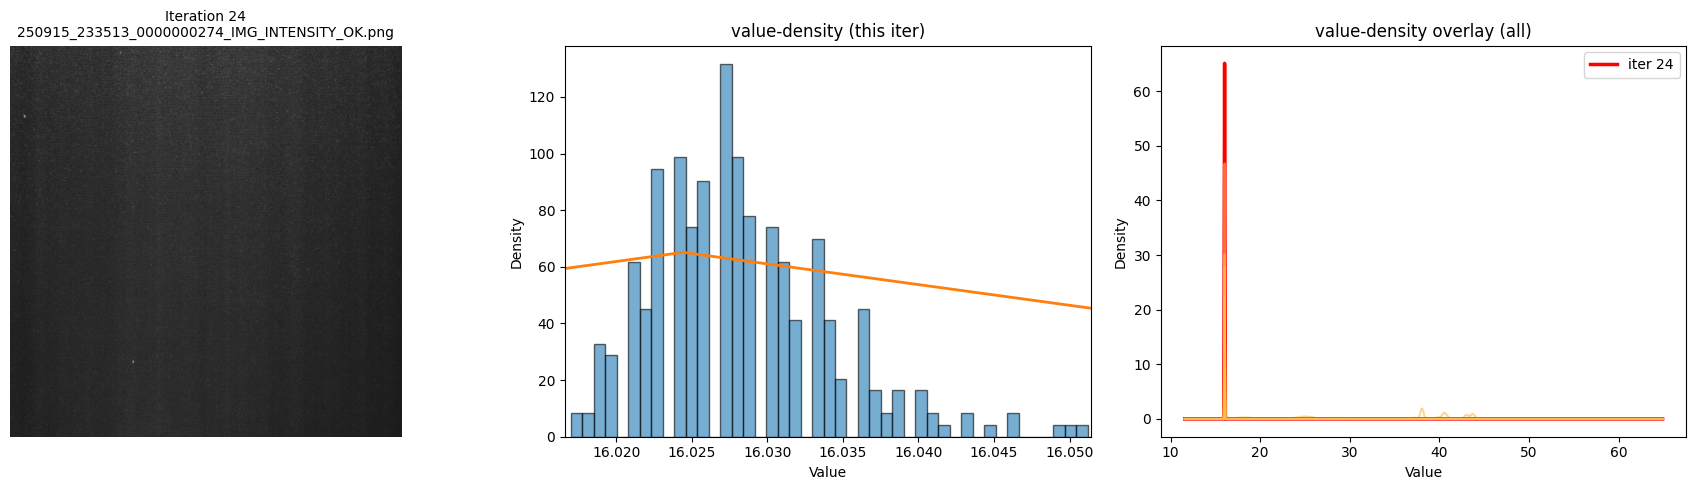

iter = 25

score = -0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.038
  - std_val: 0.008

parameters
  - acquisition: qLogNEI
  - pressure: 450.0
  - velocity: 40.0
  - wall_spacing: 0.2
  - number_of_layers: 3.5


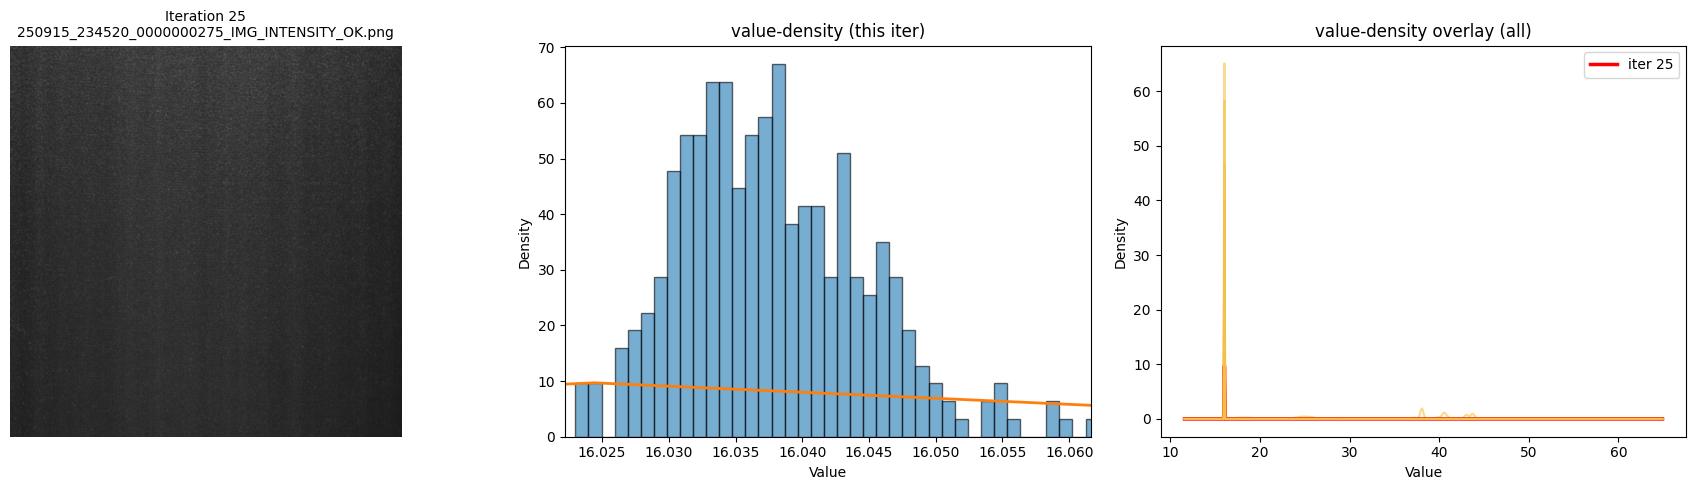

iter = 26

score = 0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.036
  - std_val: 0.007

parameters
  - acquisition: qLogNEI
  - pressure: 500.0
  - velocity: 20.0
  - wall_spacing: 1.0
  - number_of_layers: 8.5


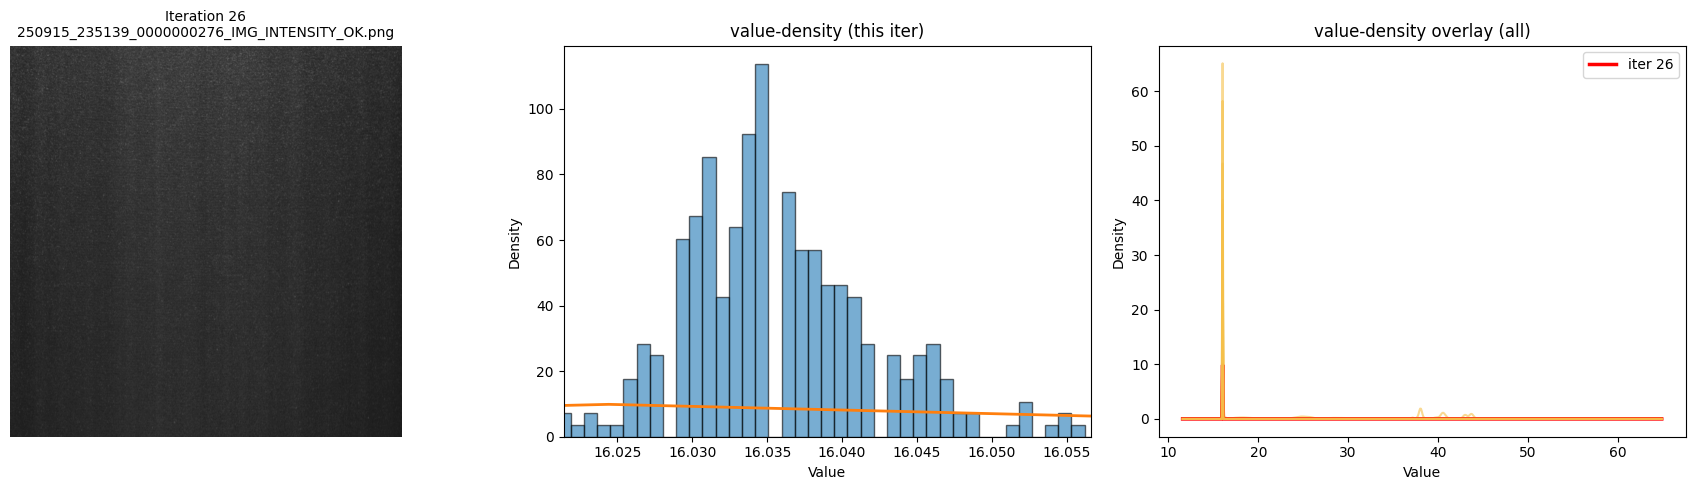

iter = 27

score = -0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.035
  - std_val: 0.011

parameters
  - acquisition: qLogNEI
  - pressure: 450.0
  - velocity: 40.0
  - wall_spacing: 1.0
  - number_of_layers: 8.5


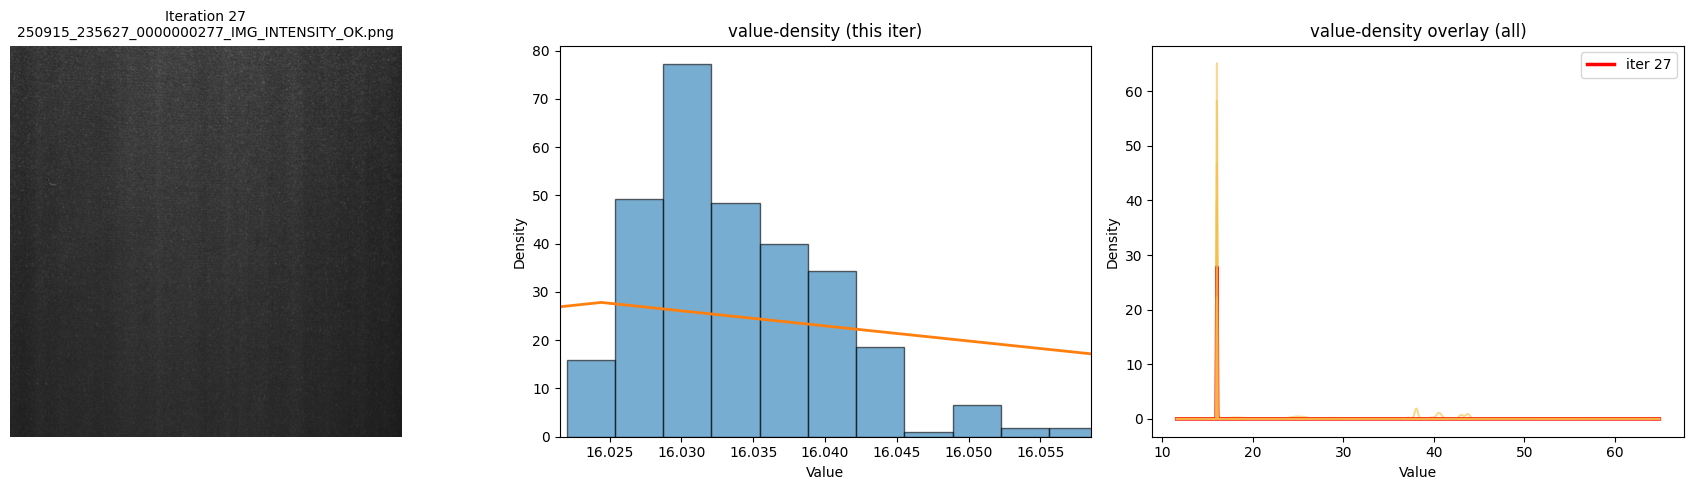

iter = 28

score = -0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.035
  - std_val: 0.007

parameters
  - acquisition: qLogNEI
  - pressure: 500.0
  - velocity: 20.0
  - wall_spacing: 1.0
  - number_of_layers: 3.5


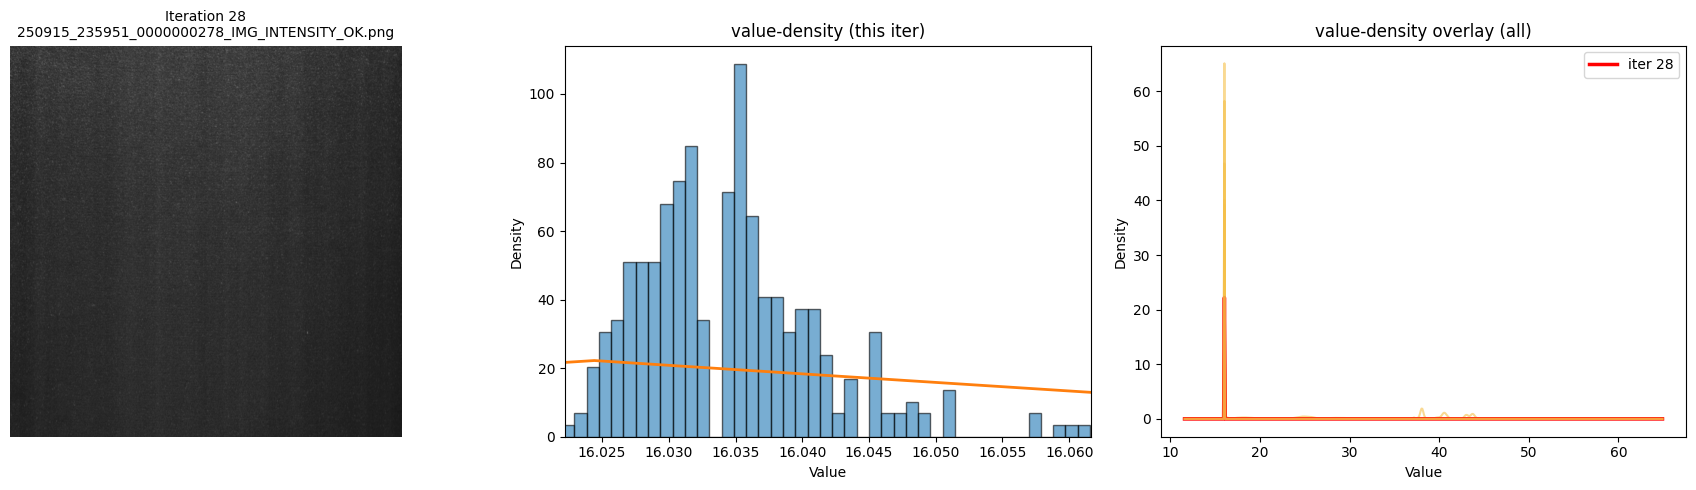

iter = 29

score = -0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.035
  - std_val: 0.009

parameters
  - acquisition: qLogNEI
  - pressure: 500.0
  - velocity: 20.0
  - wall_spacing: 0.611
  - number_of_layers: 8.5


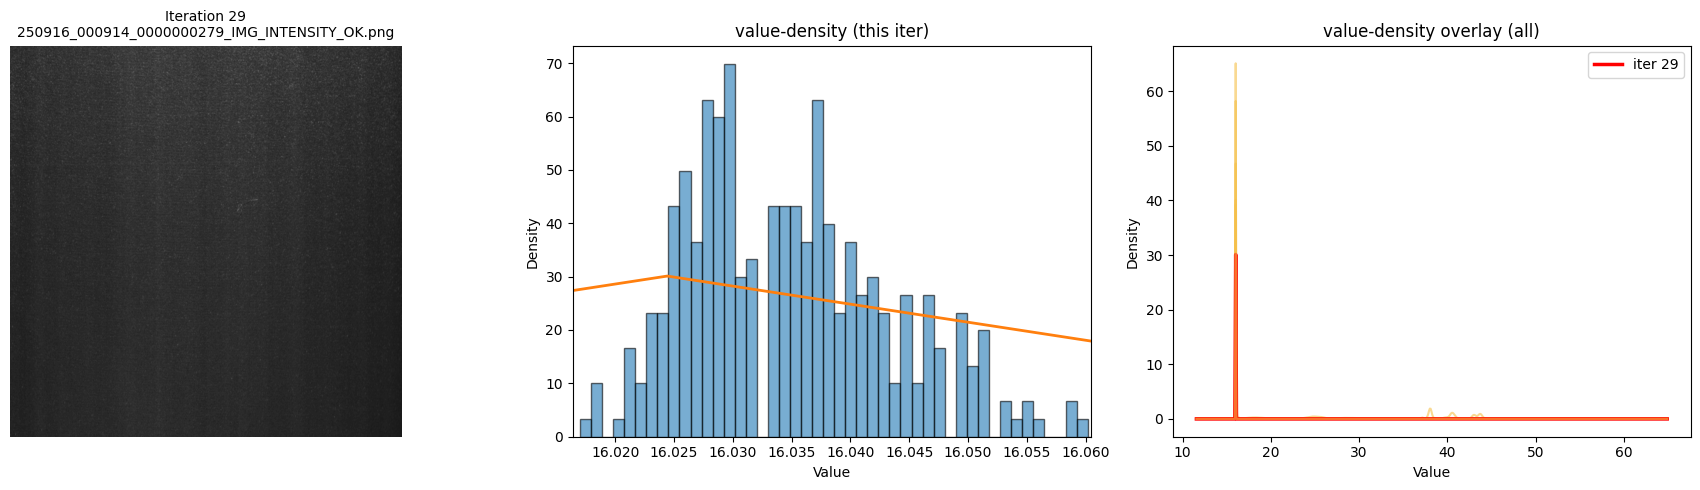

iter = 30

score = -0.0

profile analysis
  - norm_avg: 0.001
  - norm_std: 0.001
  - avg_val: 16.031
  - std_val: 0.007

parameters
  - acquisition: qLogNEI
  - pressure: 500.0
  - velocity: 40.0
  - wall_spacing: 0.2
  - number_of_layers: 3.5


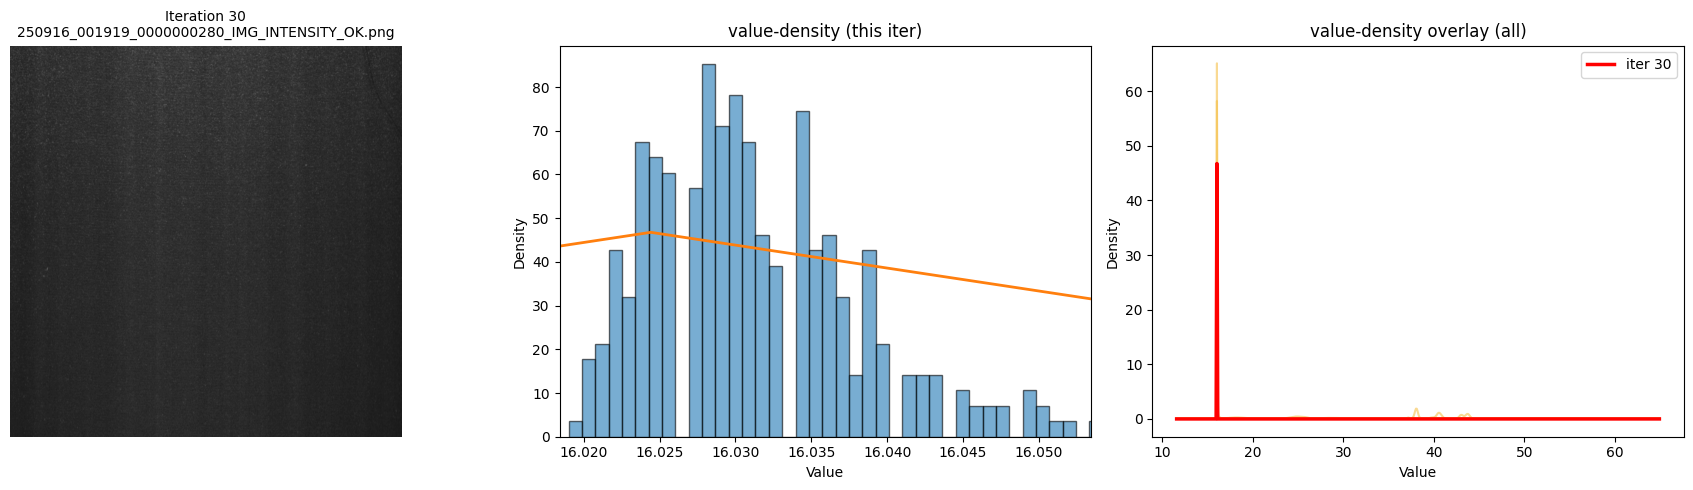

Stopped at iteration 31: iteration은 1~30 범위여야 합니다.


In [5]:

iter_num = 1

while True:
    try:
        show_iteration(
            iteration=iter_num
        )
        iter_num += 1
    except Exception as e:
        print(f"Stopped at iteration {iter_num}: {e}")
        break
